In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
%matplotlib notebook

In [2]:
#get path to network folder with lims images for this mouse
mouse_num = '421323'
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
print(vimg_path)

\\allen/programs/braintv/production/visualbehavior/prod0/specimen_769292015/isi_experiment_777042004/777042004_target_map.tif


In [3]:
#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimg = cv2.imread(r'Z:\04252019\2019_04_25_15_42_16_left.png')

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]

In [4]:
#class to handle annotating the images with points of interest
#USE: left mouse clicks will draw red dots on image and populate a list of x y coordinates for each dot
#     right mouse clicks will clear the dots and the x y coordinate list
class pointAnnotator:
    def __init__(self, im, ax):
        self.ax = ax
        self.ax.set_xlim([0,im.get_array().shape[1]])
        self.ax.set_ylim([im.get_array().shape[0],0])
        
        self.im = im
        self.xs = []
        self.ys = []
        self.annos = []
        self.labels = []
        self.cid = im.figure.canvas.mpl_connect('button_press_event', self.onclick)

    def onclick(self, event):
        if event.button == 1:
            print('x ' + str(event.xdata) + '\ty ' + str(event.ydata))
            self.xs.append(event.xdata)
            self.ys.append(event.ydata)
            
            anno, = self.ax.plot(event.xdata, event.ydata, 'ro')
            self.annos.append(anno)
            lab = self.ax.text(event.xdata+0.2, event.ydata+0.2, str(len(self.annos)))
            self.labels.append(lab)
            self.im.figure.canvas.draw()  
        else:# event.button==2:
#            print(event.button)
            self.resetAnnotations()
    
    def resetAnnotations(self):
        self.xs=[]
        self.ys=[]
        for a, l in zip(self.annos, self.labels):
            a.remove()
            l.remove()
        self.im.figure.canvas.draw()
        self.annos=[]
        self.labels=[]
    
    

<IPython.core.display.Javascript object>


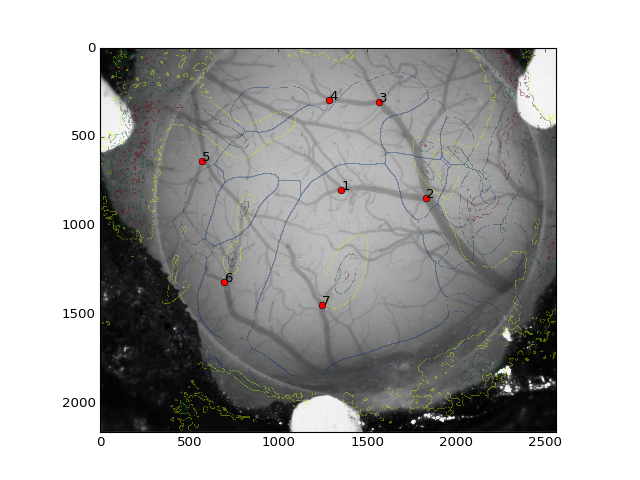

In [5]:
#Display the vasculature image and select points of interest (at least three)
vfig, vax = plt.subplots()
vim = vax.imshow(vimg, origin='upper')
vpa = pointAnnotator(vim, vax)


<IPython.core.display.Javascript object>


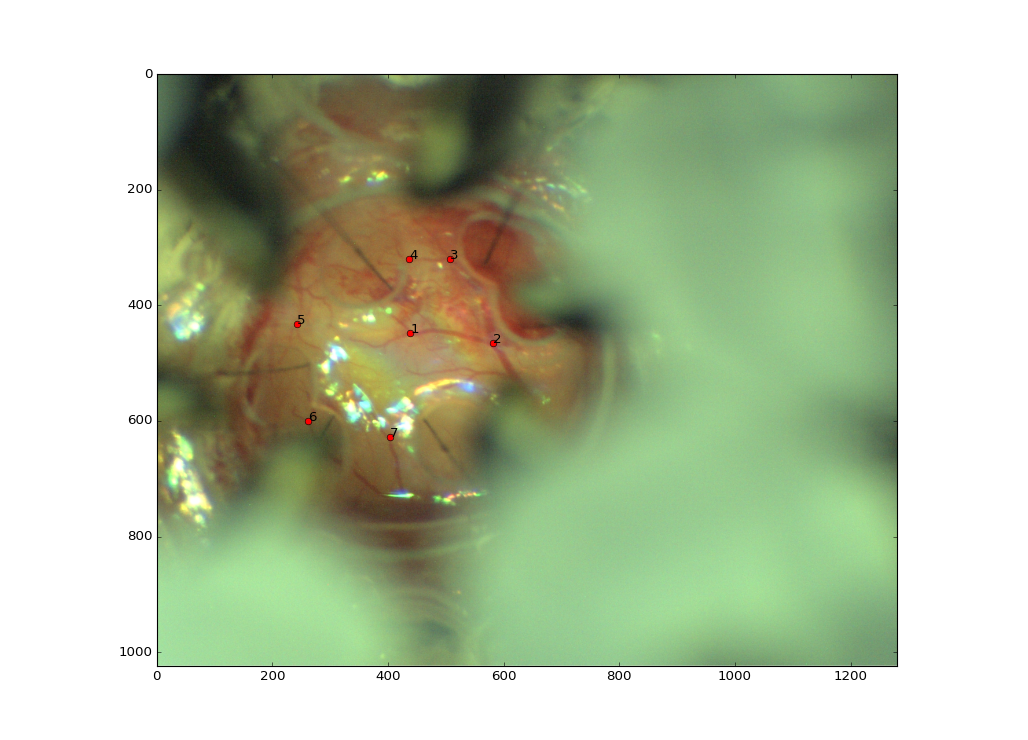

In [6]:
#Display the probe insertion image and click the matching points from the vasuclature image (must be in same order)
pfig, pax = plt.subplots()
pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)

[[437.9964  447.94232]
 [581.56396 465.23965]
 [507.18558 319.94235]
 [436.26666 319.94235]
 [242.53694 432.3748 ]
 [261.56396 600.15857]
 [403.4018  627.8342 ]]
[[1353.5     795.9375]
 [1831.625   840.9375]
 [1567.25    300.9375]
 [1286.      289.6875]
 [ 571.625   632.8125]
 [ 695.375  1313.4375]
 [1246.625  1442.8125]]


<IPython.core.display.Javascript object>


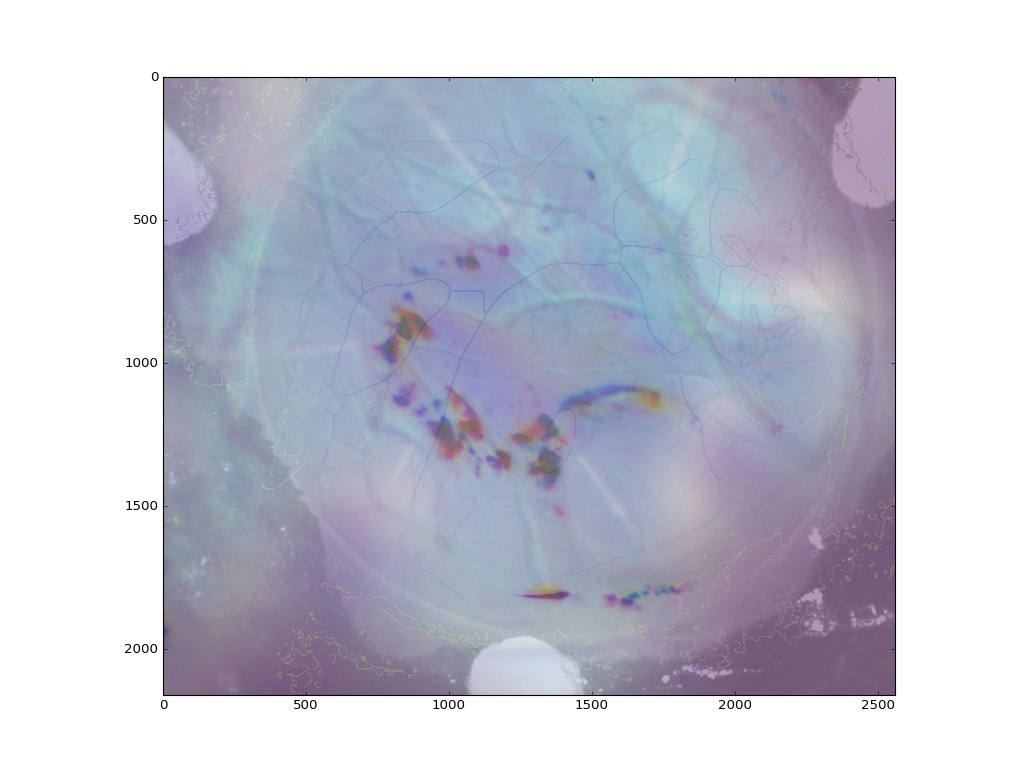

In [7]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates
ppoints = np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = np.stack((vpa.xs, vpa.ys)).astype(np.float32).T
print(ppoints)
print(vpoints)
#aff = cv2.estimateRigidTransform(ppoints, vpoints, False)
#pimg_aff = cv2.warpAffine(pimg, aff, (vimg.shape[1], vimg.shape[0]))
#perspective = cv2.getPerspectiveTransform(ppoints,vpoints)
perspective = cv2.findHomography(ppoints, vpoints)
pimg_aff = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

fig, ax = plt.subplots()
ax.imshow(vimg, alpha=0.5)
ax.imshow(255-pimg_aff, alpha=0.5)
# p_green = np.squeeze(pimg_aff[:, :, 1])
# im = ax.imshow(vimg[:, :, 1], cmap='Blues', alpha=0.5)
# ax.imshow(255-p_green, cmap='Reds', alpha=0.5)

# array = im.get_array()
# #im2 = ax.imshow(vimg, alpha=0.4)
# @interact(high=[0, 1, 0.01], low=[0,1,0.01])
# def imshow_contrast(high=1, low=0.5):
#     vimg_c = np.copy(array)
#     vimg_c[vimg_c>high*vimg_c.max()] = 255
#     vimg_c[vimg_c<low*vimg_c.max()] = 0
    
#     im.set_array(vimg_c)
    
#     display(fig)


<IPython.core.display.Javascript object>


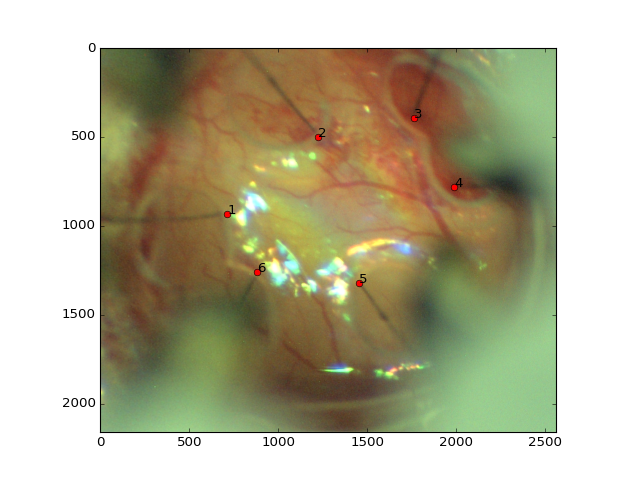

In [8]:
#Select location of probe insertion points in this warped image
paffFig, paffax = plt.subplots()
paff_im = paffax.imshow(pimg_aff, origin='upper')
paffp = pointAnnotator(paff_im, paffax)

<IPython.core.display.Javascript object>


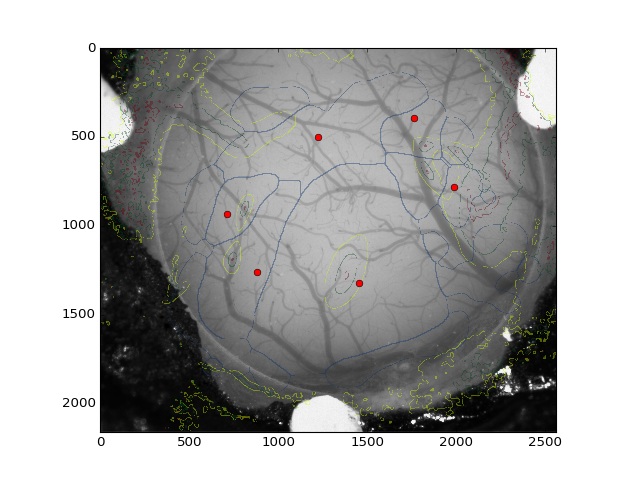

In [9]:
#Plot probe insertion points on vasculature image to double check that it looks reasonable
paffpoints = np.stack((paffp.xs, paffp.ys)).astype(np.float32).T
fig, ax = plt.subplots()
ax.imshow(vimg, origin='upper')
ax.set_xlim([0, vimg.shape[1]])
ax.set_ylim([vimg.shape[0], 0])
for p in paffpoints:
    ax.plot(p[0], p[1], 'ro')